In [1]:
!python --version

Python 3.11.10


In [3]:
!pip install scanpy scikit-misc scvi-tools mplscience igraph leidenalg

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 146.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 158.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 171.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 165.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 MB 151.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 217.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 161.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 168.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import os
os.chdir('/workspace')
import gc
import warnings
warnings.filterwarnings("ignore")

# single cell pipelines
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

# scvi-tools
import scvi
import torch

print(scvi.__version__)
sc.logging.print_header()

np.random.seed(777)
torch.manual_seed(777)
scvi.settings.seed = 777

1.2.1


Seed set to 777


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.3 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.6.0 statsmodels==0.14.4 pynndescent==0.5.13


In [5]:
!pwd

/workspace


In [6]:
batch_key = 'sample_id'

# 1. autotune

In [7]:
!pip install ray[tune] hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 128.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 179.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 133.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
from scvi import autotune
from ray import tune
import ray

In [9]:
!ls

1_before_integration.h5ad


In [21]:
adata = sc.read_h5ad('1_before_integration.h5ad')
adata

AnnData object with n_obs × n_vars = 62649 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet'
    layers: 'counts'

In [22]:
np.max(adata.X), np.min(adata.X)

(4177.0, 0.0)

In [23]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer = 'counts', flavor = 'seurat_v3', batch_key = batch_key, span = 0.5) 

In [27]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, layer = 'counts', batch_key = batch_key)

In [28]:
search_space = {
    "model_params": {
        "n_hidden" : tune.choice([92, 128, 192, 256]),
        "n_latent" : tune.choice([10, 20, 30, 40, 50, 60]),
        "n_layers" : tune.choice([1,2,3]),
        "gene_likelihood" : tune.choice(["nb", "zinb"])
    },
    "train_params" : {
        "max_epochs" : 100, 
        "plan_kwargs": {
            "lr": tune.loguniform(1e-4, 1e-2)
        },
        "datasplitter_kwargs": {
            "drop_last": True,
        }
    }
}

In [30]:
ray.init(log_to_driver=False)

2024-12-18 21:15:18,242	WARNING utils.py:580 -- Detecting docker specified CPUs. In previous versions of Ray, CPU detection in containers was incorrect. Please ensure that Ray has enough CPUs allocated. As a temporary workaround to revert to the prior behavior, set `RAY_USE_MULTIPROCESSING_CPU_COUNT=1` as an env var before starting Ray. Set the env var: `RAY_DISABLE_DOCKER_CPU_WARNING=1` to mute this warning.
2024-12-18 21:15:18,244	WARNING utils.py:592 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 20.4 to 20.
2024-12-18 21:15:19,524	INFO worker.py:1821 -- Started a local Ray instance.


Python version:,3.11.10
Ray version:,2.40.0


In [31]:
results = autotune.run_autotune(model_cls, data = adata, mode = "min",  metrics = "validation_loss", search_space = search_space, num_samples = 100, resources = {"cpu" : 20, "gpu" : 1})

2024-12-18 23:43:46,959	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/workspace/scvi_log/scvi_2cb73ac0-9536-40de-9ddc-57cfc53f587a/scvi_2cb73ac0-9536-40de-9ddc-57cfc53f587a' in 0.0654s.
2024-12-18 23:43:47,009	INFO tune.py:1041 -- Total run time: 8901.86 seconds (8901.70 seconds for the tuning loop).


In [33]:
best_vl, best_i = 10000, 0
for i, res in enumerate(results.result_grid):
    vl = res.metrics['validation_loss']
    if vl < best_vl:
        best_vl = vl
        best_i = i
# get hyperparameter        
results.result_grid[best_i]

Result(
  metrics={'validation_loss': 582.1892700195312},
  path='/workspace/scvi_log/scvi_2cb73ac0-9536-40de-9ddc-57cfc53f587a/scvi_2cb73ac0-9536-40de-9ddc-57cfc53f587a/_trainable_819a12c0_33_gene_likelihood=zinb,n_hidden=192,n_latent=50,n_layers=1,drop_last=True,max_epochs=100,lr=0.0051_2024-12-18_23-05-03',
  filesystem='local',
  checkpoint=None
)

# 2. scVI
- change params

In [34]:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts', batch_key='sample_id')
scvi_model = scvi.model.SCVI(adata, gene_likelihood='zinb', n_hidden=192, n_latent=50, n_layers=1, dropout_rate= 0.5)  

In [35]:
scvi_model.train(early_stopping=True, datasplitter_kwargs={"drop_last": True}, plan_kwargs={"lr": 0.0051},)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/128 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=128` reached.


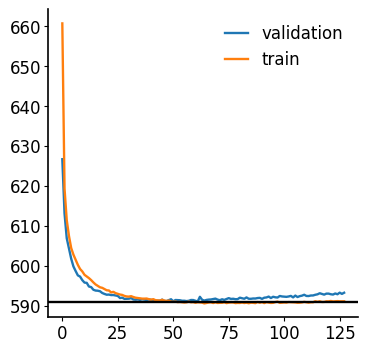

In [36]:
with mplscience.style_context():
    y = scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(scvi_model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(scvi_model.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [37]:
# read again
adata = sc.read_h5ad('1_before_integration.h5ad')
adata.obsm['X_scVI'] = scvi_model.get_latent_representation()
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 62649 × 36579
    obs: 'sample_id', 'tissue', 'patient_id', 'author', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet'
    obsm: 'X_scVI'
    layers: 'counts'

In [42]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

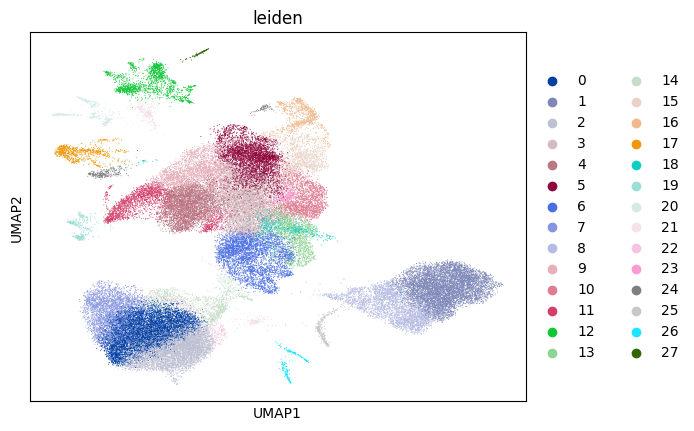

In [43]:
sc.pl.umap(adata, color = 'leiden')

In [44]:
adata.write('2_after_scvi_autotune.h5ad')
scvi_model.save('model_scvi_autotune')

# 3. scANVI

In [ ]:
# scvi_model = scvi.model.SCVI.load('model_path', adata)

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model= scvi_model, adata = adata, labels_key = 'cell_type', unlabeled_category='unlabelled')

In [ ]:
scanvi_model.train(max_epochs = 30, early_stopping = True)

# scanvi_model.train(
#     max_epochs=30,
#     early_stopping=True,
#     early_stopping_monitor="validation_loss",
#     early_stopping_patience=10,
#     plan_kwargs={
#         "lr": 1e-3,           
#         "weight_decay": 1e-4, 
#         "n_epochs_kl_warmup": 5  
#     }
# )

In [ ]:
# read again
adata = sc.read_h5ad('')
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation()

In [ ]:
scanvi_model.save('model_scanvi')